In [548]:
from tensorflow import keras
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd
import os

In [573]:
file_list = os.listdir('./results/')
n_res = len(file_list)

In [574]:
nn_input_list = []
nn_output_list = []
for file_i in file_list:
    res = do_mpc.data.load_results('./results/'+file_i)

    phi = res['simulator']['_x', 'phi'].flatten()
    theta = res['simulator']['_x', 'theta'].flatten()
    u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
    psi = res['simulator']['_x', 'psi'].flatten()
    E_0 = res['simulator']['_p', 'E_0'].flatten()
    v_0 = res['simulator']['_p', 'v_0'].flatten()
        
    phi = np.roll(phi, -1)
    theta = np.roll(theta, -1)
    psi = np.roll(psi, -1)
        
    phi = phi[:-1]
    theta = theta[:-1]
    u_tilde = u_tilde[:-1]
    psi = psi[:-1]
    E_0 = E_0[:-1]
    v_0 = v_0[:-1]
    
    phi_dist = phi+0.01*np.random.randn(phi.shape[0])
    theta_dist = theta+0.01*np.random.randn(theta.shape[0])

    nn_input = {'phi':phi_dist, 'theta': theta_dist, 'u_tilde': u_tilde}
    nn_output = {'phi':phi, 'theta': theta, 'psi': psi}#  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

    nn_input_df = pd.DataFrame.from_dict(nn_input)
    nn_output_df = pd.DataFrame.from_dict(nn_output)

    nn_input_list.append(nn_input_df)
    nn_output_list.append(nn_output_df)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [575]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = model_selection.train_test_split(nn_input_list, nn_output_list)

In [576]:
y_scaling = pd.concat(nn_output_train).abs().max().to_numpy()
x_scaling = pd.concat(nn_input_train).abs().max().to_numpy()

In [577]:
y_scaling

array([1.29831598, 1.31173016, 3.1460901 ])

In [578]:
n_datasets = len(nn_input_train)
seq_length = 10  # length of sequence for ANN training

n_data = nn_input_train[0].shape[0]
n_seq = (n_data // seq_length) - 1

# create sequences from the data:
X = []
Y = []
# for data_i in range(n_datasets):
#     X_train = nn_input_train[data_i].to_numpy()
#     Y_train = nn_output_train[data_i].to_numpy()
#     for offset in range(seq_length):
#         for data_sample in range(n_seq-1):
#             start_ind = data_sample*seq_length+offset
#             X.append(X_train[start_ind:start_ind + seq_length, :])
#             Y.append(Y_train[start_ind:start_ind + seq_length, :])

for data_sample in range(n_seq):
    for data_i in range(n_datasets):
        X_train = nn_input_train[data_i].to_numpy()
        Y_train = nn_output_train[data_i].to_numpy()
        for offset in range(seq_length):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :]/x_scaling)
            Y.append(Y_train[start_ind:start_ind + seq_length, :]/y_scaling)

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = seq_length*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [579]:
batch_size

240

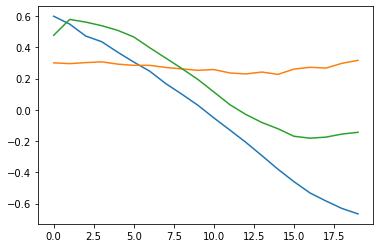

In [580]:
n= 15
plt.plot(np.concatenate((X[0+n],X[batch_size+n])))

We obtain the following training data shape:

In [581]:
X.shape

(16320, 10, 3)

Note that with the batch_size:

In [582]:
batch_size

240

WE obtain

In [583]:
X.shape[0]/batch_size

68.0

consecutive sequences for each batch.

# Create RNN:

In [584]:
stateful = True
n_layer = 3  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [30]
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 30
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (240, 10, 30)             4080      
_________________________________________________________________
time_distributed_179 (TimeDi (240, 10, 30)             930       
_________________________________________________________________
time_distributed_180 (TimeDi (240, 10, 30)             930       
_________________________________________________________________
time_distributed_181 (TimeDi (240, 10, 30)             930       
_________________________________________________________________
time_distributed_182 (TimeDi (240, 10, 3)              93        
Total params: 6,963
Trainable params: 6,963
Non-trainable params: 0
_________________________________________________________________


In [585]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

history = model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=500, verbose=1, shuffle=False)

Train on 16320 samples
Epoch 1/500
16320/16320 [==============================] - 2s 103us/sample - loss: 0.0831
Epoch 2/500
16320/16320 [==============================] - 1s 40us/sample - loss: 0.0201
Epoch 3/500
16320/16320 [==============================] - 1s 41us/sample - loss: 0.0172
Epoch 4/500
16320/16320 [==============================] - 1s 41us/sample - loss: 0.0157
Epoch 5/500
16320/16320 [==============================] - 1s 39us/sample - loss: 0.0152
Epoch 6/500
16320/16320 [==============================] - 1s 57us/sample - loss: 0.0148
Epoch 7/500
16320/16320 [==============================] - 1s 44us/sample - loss: 0.0144
Epoch 8/500
16320/16320 [==============================] - 1s 40us/sample - loss: 0.0140
Epoch 9/500
16320/16320 [==============================] - 1s 42us/sample - loss: 0.0135
Epoch 10/500
16320/16320 [==============================] - 1s 47us/sample - loss: 0.0130
Epoch 11/500
16320/16320 [==============================] - 1s 43us/sample - loss: 0.

16320/16320 [==============================] - 1s 38us/sample - loss: 0.0018
Epoch 92/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0019
Epoch 93/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0015
Epoch 94/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0017
Epoch 95/500
16320/16320 [==============================] - 1s 38us/sample - loss: 0.0015
Epoch 96/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0016
Epoch 97/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0014
Epoch 98/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0014
Epoch 99/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0016
Epoch 100/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0014
Epoch 101/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0016
Epoch 102/500
16320/1

16320/16320 [==============================] - 1s 38us/sample - loss: 6.9871e-04
Epoch 181/500
16320/16320 [==============================] - 1s 37us/sample - loss: 6.8520e-04
Epoch 182/500
16320/16320 [==============================] - 1s 37us/sample - loss: 7.3003e-04
Epoch 183/500
16320/16320 [==============================] - 1s 39us/sample - loss: 7.0375e-04
Epoch 184/500
16320/16320 [==============================] - 1s 37us/sample - loss: 7.3754e-04
Epoch 185/500
16320/16320 [==============================] - 1s 37us/sample - loss: 8.0220e-04
Epoch 186/500
16320/16320 [==============================] - 1s 37us/sample - loss: 0.0010
Epoch 187/500
16320/16320 [==============================] - 1s 39us/sample - loss: 9.3178e-04
Epoch 188/500
16320/16320 [==============================] - 1s 39us/sample - loss: 0.0011
Epoch 189/500
16320/16320 [==============================] - 1s 36us/sample - loss: 8.9624e-04
Epoch 190/500
16320/16320 [==============================] - 1s 38us/sam

16320/16320 [==============================] - 1s 39us/sample - loss: 5.0174e-04
Epoch 267/500
16320/16320 [==============================] - 1s 37us/sample - loss: 6.8414e-04
Epoch 268/500
16320/16320 [==============================] - 1s 40us/sample - loss: 7.3302e-04
Epoch 269/500
16320/16320 [==============================] - 1s 37us/sample - loss: 6.9589e-04
Epoch 270/500
16320/16320 [==============================] - 1s 37us/sample - loss: 5.4731e-04
Epoch 271/500
16320/16320 [==============================] - 1s 39us/sample - loss: 5.8144e-04
Epoch 272/500
16320/16320 [==============================] - 1s 37us/sample - loss: 7.6633e-04
Epoch 273/500
16320/16320 [==============================] - 1s 37us/sample - loss: 5.6412e-04
Epoch 274/500
16320/16320 [==============================] - 1s 38us/sample - loss: 4.4019e-04
Epoch 275/500
16320/16320 [==============================] - 1s 39us/sample - loss: 5.4965e-04
Epoch 276/500
16320/16320 [==============================] - 1s 

16320/16320 [==============================] - 1s 40us/sample - loss: 5.0693e-04
Epoch 353/500
16320/16320 [==============================] - 1s 37us/sample - loss: 5.4834e-04
Epoch 354/500
16320/16320 [==============================] - 1s 38us/sample - loss: 6.3417e-04
Epoch 355/500
16320/16320 [==============================] - 1s 41us/sample - loss: 5.0498e-04
Epoch 356/500
16320/16320 [==============================] - 1s 40us/sample - loss: 3.4224e-04
Epoch 357/500
16320/16320 [==============================] - 1s 38us/sample - loss: 4.1675e-04
Epoch 358/500
16320/16320 [==============================] - 1s 40us/sample - loss: 4.3538e-04
Epoch 359/500
16320/16320 [==============================] - 1s 40us/sample - loss: 4.4913e-04
Epoch 360/500
16320/16320 [==============================] - 1s 40us/sample - loss: 5.0581e-04
Epoch 361/500
16320/16320 [==============================] - 1s 40us/sample - loss: 4.4373e-04
Epoch 362/500
16320/16320 [==============================] - 1s 

16320/16320 [==============================] - 1s 38us/sample - loss: 3.8386e-04
Epoch 439/500
16320/16320 [==============================] - 1s 37us/sample - loss: 3.5102e-04
Epoch 440/500
16320/16320 [==============================] - 1s 37us/sample - loss: 3.0818e-04
Epoch 441/500
16320/16320 [==============================] - 1s 37us/sample - loss: 3.1082e-04
Epoch 442/500
16320/16320 [==============================] - 1s 38us/sample - loss: 2.7719e-04
Epoch 443/500
16320/16320 [==============================] - 1s 37us/sample - loss: 3.0259e-04
Epoch 444/500
16320/16320 [==============================] - 1s 36us/sample - loss: 2.6094e-04
Epoch 445/500
16320/16320 [==============================] - 1s 38us/sample - loss: 3.2450e-04
Epoch 446/500
16320/16320 [==============================] - 1s 36us/sample - loss: 2.6154e-04
Epoch 447/500
16320/16320 [==============================] - 1s 38us/sample - loss: 3.1451e-04
Epoch 448/500
16320/16320 [==============================] - 1s 

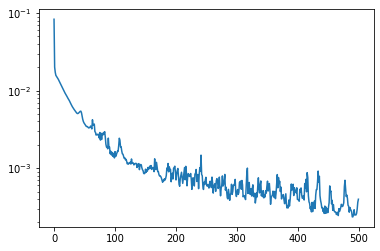

In [586]:
plt.semilogy(history.history['loss'])

# Evaluate Model
To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [587]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=True)
#model_simple.compile(loss='mse', optimizer='Adam')

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (1, 1, 30)                4080      
_________________________________________________________________
time_distributed_183 (TimeDi (1, 1, 30)                930       
_________________________________________________________________
time_distributed_184 (TimeDi (1, 1, 30)                930       
_________________________________________________________________
time_distributed_185 (TimeDi (1, 1, 30)                930       
_________________________________________________________________
time_distributed_186 (TimeDi (1, 1, 3)                 93        
Total params: 6,963
Trainable params: 6,963
Non-trainable params: 0
_________________________________________________________________


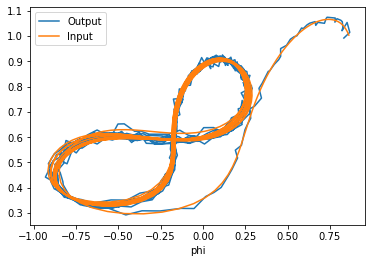

In [592]:
test_with = 5
nn_output_i = nn_output_test[test_with]
nn_input_i = nn_input_test[test_with]

fig,ax =plt.subplots()

nn_input_i.plot(x='phi', y='theta', label='Output', ax=ax)
nn_output_i.plot(x='phi', y='theta', label='Input', ax=ax)

In [593]:
model_simple.reset_states()
nn_input_i = nn_input_test[test_with]
nn_output_i = nn_output_test[test_with]


res = []

for i,in_i in nn_input_i.iterrows():
    rnn_in = in_i.to_numpy().reshape(1,-1)/x_scaling
    #rnn_in *= (1+0.1*np.random.randn(rnn_in.shape[0]))
    rnn_out = model_simple.predict(rnn_in.reshape(1,1,-1))*y_scaling
    res.append(rnn_out)
res = np.concatenate(res, axis=0).squeeze()
res_df = pd.DataFrame(res, columns = nn_output_i.keys())

Text(0, 0.5, 'psi')

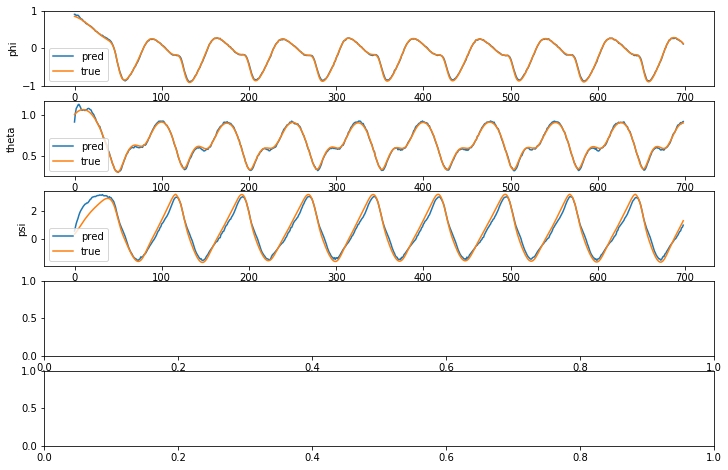

In [594]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_i.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_i.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_i.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

# res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
# nn_output_i.plot(y=['E_0'], ax=ax[3], label=['true'])
# ax[3].set_ylabel('E_0')

# res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
# nn_output_i.plot(y=['v_0'], ax=ax[4], label=['true'])
# ax[4].set_ylabel('v_0')

In [595]:
model_no = '006'

if True:
    model_simple.save_weights('./models/{model}_RNN/{model}_RNN_weights'.format(model=model_no))
    with open('./models/{model}_RNN/{model}_RNN_config.pkl'.format(model=model_no), 'wb') as f:
        pickle.dump({'model_param':model_param, 'y_scaling':y_scaling, 'x_scaling':x_scaling}, f)